In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import pandas as pd
import requests

from tweet_parser.tweet import Tweet
from gapi import gnipapi
from gapi.gnipapi import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This will lean heavily on Tom Augspurger's excellent series on Modern Pandas.


Quote:

    Method chaining, where you call methods on an object one after another, is in vogue at the moment. It's always been a style of programming that's been possible with pandas, and over the past several releases, we've added methods that enable even more chaining.

    - assign (0.16.0): For adding new columns to a DataFrame in a chain (inspired by dplyr's mutate)
    - pipe (0.16.2): For including user-defined methods in method chains.
    - rename (0.18.0): For altering axis names (in additional to changing the actual labels as before).

    - Window methods (0.18): Took the top-level pd.rolling\_\* and pd.expanding\_\* functions and made them NDFrame methods with a groupby-like API.
    - Resample (0.18.0) Added a new groupby-like API
    - .where/mask/Indexers accept Callables (0.18.1): In the next release you'll be able to pass a callable to the indexing methods, to be evaluated within the DataFrame's context (like .query, but with code instead of strings).

    My scripts will typically start off with large-ish chain at the start getting things into a manageable state. It's good to have the bulk of your munging done with right away so you can start to do Science™:
    
    
Part of the goal will be to develop different coding styles with Pandas, moving from a script-ish, verbose approach to a piped style that flows well with discrete cleaning operations grouped into single functions. This flows very well into using pyspark's dataframe as well, as pyspark *requires* that kind of style and there is a great deal of overlap with pandas' dataframe methods in pyspark.   


Method chains are a popular method in programming these days, with the rise of functional languages that can change function composition to be more readable. Examples of this in various languages:

```.scala
 def fooNotIndent : List[Int] = (1 to 100).view.map { _ + 3 }.filter { _ > 10 }.flatMap { table.get }.take(3).toList

  def fooIndent: List[Int] =
  (1 to 100)
    .view
    .map { _ + 3 }
    .filter { _ > 10 }
    .flatMap { table.get }
    .take(3)
    .toList
```


or comparing (from TA's post)


```
tumble_after(
    broke(
        fell_down(
            fetch(went_up(jack_jill, "hill"), "water"),
            jack),
        "crown"),
    "jill"
)
```

with (from TA's post)

```
jack_jill %>%
    went_up("hill") %>%
    fetch("water") %>%
    fell_down("jack") %>%
    broke("crown") %>%
    tumble_after("jill")
    
```

or

```
jack_jill 
    .pipe(went("hill", "up"))
    .pipe(fetch("water"))
    .pipe(fell_down("jack"))
    .pipe(broke("crown"))
    .pipe(tumble_after("jill"))
``` 



There are several cases I'd like to address in this session -

1. Effective pandas usage
2. Interactive development strategies
3. Balancing exploration and reproducability
4. Joining heterogenous datatypes


This might be a lot for a single session, but hey. 

Let's start off with a problem that we might have that we can try to answer:


## What Airports or flights have issues with delays?

I am purposefully choosing a dataset that we will have difficulties in joining with twitter data, and also to illustrate a point...

Let's use Tom's use of the BTS airline delay dataset, which requires a bit of work to obtain and parse through.



In data work, I have a loose set of semantics to describe stages in a workflow:

### Research and understanding
- understand question of interest
- understand the data sources available
- evaluate requirements from stakeholders
- think about available methods and timeframes for implementation
- judge final output (serialized data, production model, figures / slides / report, etc)

    
### data gathering / pull
- a single stage of collecting data from some source, be it scraping a website, some form of database, reading from a csv or other binary file, etc.
    
    
### trivial cleaning
- dealing with various data sources returns data in formats that you may not want, be it with weird variable names, transformations from CamelCase to camel_case, or other very early-stages ops that you define to ease the rest of the process. E.g., renaming columns with spaces in them to be `_` delinated. This can often be integrated into the basic data pull step, but should be explicit for reproducibility purposes.
    
    
### Non-trivial cleaning / preprocessing
- There might be missing data, multiple or non-standard representation of NULL values (99s, strings 'nan', etc), which finding and handling are crucial
- for JSON or similar formats, nested data structures might be present
- datetime parsing and conversion if important to underlying analysis
- reshaping data to facilitate analysis (wide to long, stacked to unstacked, etc).
- frequency normalization for time-series data
- text cleaning or tokenization
- joining additional data sources with current data (which has already be gathered and pulled)


### exploratory analysis
- with "clean" data, you can begin to poke at questions, from basic summarization and counting to faceted charts if it makes sense for the data
- may include branching by reformatting your data into a different set (single operations to aggregated buckets, denormalized time-series stats, etc)
- lots of plotting and descriptions
- often can loop back to previous stages to gather more data or stabilize workflow when finding good features or ways of processing data


### modeling / prediction
- potential input to ML functions, which includes sampling and so forth
- output could be predicted values for a database or downstream operation, figures and text for a report, etc.
    
   
   
It's important to note that these stages are NEVER LINEAR, even though it almost always looks like it to the end consumer of posts like this. Each stage can be non-trivial for a host of reasons, and choices made in the early stages have strong effects in the rest of the process. Lots of iteration might be needed in each stage, and managing technical debt here can make each iteration faster.


Given these tasks, it seems logical to define our code in simliar stages, though I have no precise guides for how to do this. In our example for today, we can start by grabbing some data from the web. We'll follow TA's flights data grab and later add some tweet data via the Gnip api.



## Let's play

What type of questions do we want to answer? Let's say we have a project that will investigate customer sentiment around airports / airlines. Perhaps some questions of interest are:

- Are customer moods affected heavily by flight delays?
- Are customers more likely to tweet due to flight delays?
- Do these effects vary by airport, airlines, or other factors?


What type of data will we need? Probably some detailed data about flight delays, preferabbly flight-level data that includes information about the carrier, airport, destination, etc. We'll also need tweet data that reasonably matches these critera, of course. In this context, we'll probably be satisfied with simple exploration.

I chose these questions partially due to the great series of posts by Augsperger that illustrate working with complex data, such as flight delays. :) 





## Data Gathering

For most notebook purposes, I like to include all imports at the top of a notebook, even if the code they enable will not be introduced until a later point. I like to keep this cell apart from others in the notebook for easy maintenence.

In [7]:
import os
import zipfile

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In the original example from Tom, the code is written out as such:

```.python
headers = {
    'Referer': 'https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time',
    'Origin': 'https://www.transtats.bts.gov',
    'Content-Type': 'application/x-www-form-urlencoded',
}

params = (
    ('Table_ID', '236'),
    ('Has_Group', '3'),
    ('Is_Zipped', '0'),
)

data = <TRUNCATED>

os.makedirs('data', exist_ok=True)
dest = "data/flights.csv.zip"

if not os.path.exists(dest):
    r = requests.post('https://www.transtats.bts.gov/DownLoad_Table.asp',
                      headers=headers, params=params, data=data, stream=True)

    with open("data/flights.csv.zip", 'wb') as f:
        for chunk in r.iter_content(chunk_size=102400): 
            if chunk:
                f.write(chunk)
```


Given out focus today, let's wrap all initial data pulling into a function for logical separation.

In [8]:
def maybe_pull_airport_data():
    """
    lightly modified from TA's post.
    
    """
    headers = {
        'Referer': 'https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time',
        'Origin': 'https://www.transtats.bts.gov',
        'Content-Type': 'application/x-www-form-urlencoded',
    }

    params = (
        ('Table_ID', '236'),
        ('Has_Group', '3'),
        ('Is_Zipped', '0'),
    )
    
    # query string to be sent. can modify the 'where' dates to change the size of data returned.

    data = "UserTableName=On_Time_Performance&DBShortName=On_Time&RawDataTable=T_ONTIME&sqlstr=+SELECT+FL_DATE%2CUNIQUE_CARRIER%2CAIRLINE_ID%2CTAIL_NUM%2CFL_NUM%2CORIGIN_AIRPORT_ID%2CORIGIN_AIRPORT_SEQ_ID%2CORIGIN_CITY_MARKET_ID%2CORIGIN%2CORIGIN_CITY_NAME%2CDEST_AIRPORT_ID%2CDEST_AIRPORT_SEQ_ID%2CDEST_CITY_MARKET_ID%2CDEST%2CDEST_CITY_NAME%2CCRS_DEP_TIME%2CDEP_TIME%2CDEP_DELAY%2CTAXI_OUT%2CWHEELS_OFF%2CWHEELS_ON%2CTAXI_IN%2CCRS_ARR_TIME%2CARR_TIME%2CARR_DELAY%2CCANCELLED%2CCANCELLATION_CODE%2CCARRIER_DELAY%2CWEATHER_DELAY%2CNAS_DELAY%2CSECURITY_DELAY%2CLATE_AIRCRAFT_DELAY+FROM++T_ONTIME+WHERE+YEAR%3D2017&varlist=FL_DATE%2CUNIQUE_CARRIER%2CAIRLINE_ID%2CTAIL_NUM%2CFL_NUM%2CORIGIN_AIRPORT_ID%2CORIGIN_AIRPORT_SEQ_ID%2CORIGIN_CITY_MARKET_ID%2CORIGIN%2CORIGIN_CITY_NAME%2CDEST_AIRPORT_ID%2CDEST_AIRPORT_SEQ_ID%2CDEST_CITY_MARKET_ID%2CDEST%2CDEST_CITY_NAME%2CCRS_DEP_TIME%2CDEP_TIME%2CDEP_DELAY%2CTAXI_OUT%2CWHEELS_OFF%2CWHEELS_ON%2CTAXI_IN%2CCRS_ARR_TIME%2CARR_TIME%2CARR_DELAY%2CCANCELLED%2CCANCELLATION_CODE%2CCARRIER_DELAY%2CWEATHER_DELAY%2CNAS_DELAY%2CSECURITY_DELAY%2CLATE_AIRCRAFT_DELAY&grouplist=&suml=&sumRegion=&filter1=title%3D&filter2=title%3D&geo=All%A0&time=January&timename=Month&GEOGRAPHY=All&XYEAR=2017&FREQUENCY=1&VarDesc=Year&VarType=Num&VarDesc=Quarter&VarType=Num&VarDesc=Month&VarType=Num&VarDesc=DayofMonth&VarType=Num&VarDesc=DayOfWeek&VarType=Num&VarName=FL_DATE&VarDesc=FlightDate&VarType=Char&VarName=UNIQUE_CARRIER&VarDesc=UniqueCarrier&VarType=Char&VarName=AIRLINE_ID&VarDesc=AirlineID&VarType=Num&VarDesc=Carrier&VarType=Char&VarName=TAIL_NUM&VarDesc=TailNum&VarType=Char&VarName=FL_NUM&VarDesc=FlightNum&VarType=Char&VarName=ORIGIN_AIRPORT_ID&VarDesc=OriginAirportID&VarType=Num&VarName=ORIGIN_AIRPORT_SEQ_ID&VarDesc=OriginAirportSeqID&VarType=Num&VarName=ORIGIN_CITY_MARKET_ID&VarDesc=OriginCityMarketID&VarType=Num&VarName=ORIGIN&VarDesc=Origin&VarType=Char&VarName=ORIGIN_CITY_NAME&VarDesc=OriginCityName&VarType=Char&VarDesc=OriginState&VarType=Char&VarDesc=OriginStateFips&VarType=Char&VarDesc=OriginStateName&VarType=Char&VarDesc=OriginWac&VarType=Num&VarName=DEST_AIRPORT_ID&VarDesc=DestAirportID&VarType=Num&VarName=DEST_AIRPORT_SEQ_ID&VarDesc=DestAirportSeqID&VarType=Num&VarName=DEST_CITY_MARKET_ID&VarDesc=DestCityMarketID&VarType=Num&VarName=DEST&VarDesc=Dest&VarType=Char&VarName=DEST_CITY_NAME&VarDesc=DestCityName&VarType=Char&VarDesc=DestState&VarType=Char&VarDesc=DestStateFips&VarType=Char&VarDesc=DestStateName&VarType=Char&VarDesc=DestWac&VarType=Num&VarName=CRS_DEP_TIME&VarDesc=CRSDepTime&VarType=Char&VarName=DEP_TIME&VarDesc=DepTime&VarType=Char&VarName=DEP_DELAY&VarDesc=DepDelay&VarType=Num&VarDesc=DepDelayMinutes&VarType=Num&VarDesc=DepDel15&VarType=Num&VarDesc=DepartureDelayGroups&VarType=Num&VarDesc=DepTimeBlk&VarType=Char&VarName=TAXI_OUT&VarDesc=TaxiOut&VarType=Num&VarName=WHEELS_OFF&VarDesc=WheelsOff&VarType=Char&VarName=WHEELS_ON&VarDesc=WheelsOn&VarType=Char&VarName=TAXI_IN&VarDesc=TaxiIn&VarType=Num&VarName=CRS_ARR_TIME&VarDesc=CRSArrTime&VarType=Char&VarName=ARR_TIME&VarDesc=ArrTime&VarType=Char&VarName=ARR_DELAY&VarDesc=ArrDelay&VarType=Num&VarDesc=ArrDelayMinutes&VarType=Num&VarDesc=ArrDel15&VarType=Num&VarDesc=ArrivalDelayGroups&VarType=Num&VarDesc=ArrTimeBlk&VarType=Char&VarName=CANCELLED&VarDesc=Cancelled&VarType=Num&VarName=CANCELLATION_CODE&VarDesc=CancellationCode&VarType=Char&VarDesc=Diverted&VarType=Num&VarDesc=CRSElapsedTime&VarType=Num&VarDesc=ActualElapsedTime&VarType=Num&VarDesc=AirTime&VarType=Num&VarDesc=Flights&VarType=Num&VarDesc=Distance&VarType=Num&VarDesc=DistanceGroup&VarType=Num&VarName=CARRIER_DELAY&VarDesc=CarrierDelay&VarType=Num&VarName=WEATHER_DELAY&VarDesc=WeatherDelay&VarType=Num&VarName=NAS_DELAY&VarDesc=NASDelay&VarType=Num&VarName=SECURITY_DELAY&VarDesc=SecurityDelay&VarType=Num&VarName=LATE_AIRCRAFT_DELAY&VarDesc=LateAircraftDelay&VarType=Num&VarDesc=FirstDepTime&VarType=Char&VarDesc=TotalAddGTime&VarType=Num&VarDesc=LongestAddGTime&VarType=Num&VarDesc=DivAirportLandings&VarType=Num&VarDesc=DivReachedDest&VarType=Num&VarDesc=DivActualElapsedTime&VarType=Num&VarDesc=DivArrDelay&VarType=Num&VarDesc=DivDistance&VarType=Num&VarDesc=Div1Airport&VarType=Char&VarDesc=Div1AirportID&VarType=Num&VarDesc=Div1AirportSeqID&VarType=Num&VarDesc=Div1WheelsOn&VarType=Char&VarDesc=Div1TotalGTime&VarType=Num&VarDesc=Div1LongestGTime&VarType=Num&VarDesc=Div1WheelsOff&VarType=Char&VarDesc=Div1TailNum&VarType=Char&VarDesc=Div2Airport&VarType=Char&VarDesc=Div2AirportID&VarType=Num&VarDesc=Div2AirportSeqID&VarType=Num&VarDesc=Div2WheelsOn&VarType=Char&VarDesc=Div2TotalGTime&VarType=Num&VarDesc=Div2LongestGTime&VarType=Num&VarDesc=Div2WheelsOff&VarType=Char&VarDesc=Div2TailNum&VarType=Char&VarDesc=Div3Airport&VarType=Char&VarDesc=Div3AirportID&VarType=Num&VarDesc=Div3AirportSeqID&VarType=Num&VarDesc=Div3WheelsOn&VarType=Char&VarDesc=Div3TotalGTime&VarType=Num&VarDesc=Div3LongestGTime&VarType=Num&VarDesc=Div3WheelsOff&VarType=Char&VarDesc=Div3TailNum&VarType=Char&VarDesc=Div4Airport&VarType=Char&VarDesc=Div4AirportID&VarType=Num&VarDesc=Div4AirportSeqID&VarType=Num&VarDesc=Div4WheelsOn&VarType=Char&VarDesc=Div4TotalGTime&VarType=Num&VarDesc=Div4LongestGTime&VarType=Num&VarDesc=Div4WheelsOff&VarType=Char&VarDesc=Div4TailNum&VarType=Char&VarDesc=Div5Airport&VarType=Char&VarDesc=Div5AirportID&VarType=Num&VarDesc=Div5AirportSeqID&VarType=Num&VarDesc=Div5WheelsOn&VarType=Char&VarDesc=Div5TotalGTime&VarType=Num&VarDesc=Div5LongestGTime&VarType=Num&VarDesc=Div5WheelsOff&VarType=Char&VarDesc=Div5TailNum&VarType=Char"

    os.makedirs('data', exist_ok=True)
    dest = "data/flights.csv.zip"

    if not os.path.exists(dest):
        r = requests.post('https://www.transtats.bts.gov/DownLoad_Table.asp',
                          headers=headers, params=params, data=data, stream=True)

        with open("data/flights.csv.zip", 'wb') as f:
            for chunk in r.iter_content(chunk_size=102400): 
                if chunk:
                    f.write(chunk)
    

    zf = zipfile.ZipFile("data/flights.csv.zip")
    fp = zf.extract(zf.filelist[0].filename, path='data/')
    df = (pd
          .read_csv(fp, parse_dates=["FL_DATE"])
          .rename(columns=str.lower) #note this takes a callable
         )
    return df
    

Our function may be a bit sloppy from a DRY standpoint, but let's be serious: there is no need for arguments in this function and no other piece of our analysis will ever touch the fields inside of here. You could argue that it could take a flexibile filename option, but again, for the purposes of this demo, that might be overkill, but refactoring the single function to take a filename argument would take a minutue or two, now that the core logic is stable. This gives us a high-level intro point for our demo, a single call to the function.

Imagine this was going to go into a much larger set of functions or a library of some sort -- the function can be moved to a python file and work out of the box, which can simply your notebook or code at the risk of making more dependencies for users and disrupting the flow of analysis for a technical consumer.


That was a lot of crap - let's get back to the data.

In [9]:
flights = maybe_pull_airport_data()

flights.head()
flights.shape
flights.info()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,unnamed: 32
0,2017-01-01,AA,19805,N3CGAA,307,11292,1129202,30325,DEN,"Denver, CO",...,1328.0,-17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,N3CGAA,307,14107,1410702,30466,PHX,"Phoenix, AZ",...,1653.0,-8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,N3EVAA,309,11278,1127803,30852,DCA,"Washington, DC",...,930.0,-14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01,AA,19805,N3NAAA,310,13303,1330303,32467,MIA,"Miami, FL",...,1646.0,-14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,N3FCAA,311,14107,1410702,30466,PHX,"Phoenix, AZ",...,107.0,28.0,0.0,NaN,0.0,0.0,12.0,0.0,16.0,NaN


(3307279, 33)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307279 entries, 0 to 3307278
Data columns (total 33 columns):
fl_date                  datetime64[ns]
unique_carrier           object
airline_id               int64
tail_num                 object
fl_num                   int64
origin_airport_id        int64
origin_airport_seq_id    int64
origin_city_market_id    int64
origin                   object
origin_city_name         object
dest_airport_id          int64
dest_airport_seq_id      int64
dest_city_market_id      int64
dest                     object
dest_city_name           object
crs_dep_time             int64
dep_time                 float64
dep_delay                float64
taxi_out                 float64
wheels_off               float64
wheels_on                float64
taxi_in                  float64
crs_arr_time             int64
arr_time                 float64
arr_delay                float64
cancelled                float64
cancellation_code        object
carrier_delay   

### Digression on pandas
Woo, we have a moderate-sized dataframe with a lot of columns, many which are NAN or non-intuitive. Let's define a few indices on the data, which assign metadata to each row and allow for fancy selection and operations along the way.




In [10]:
hdf = flights.set_index(["unique_carrier", "origin", "dest", "tail_num", "fl_date"]).sort_index()
hdf[hdf.columns[:4]].head()

airline_id  fl_num  \
unique_carrier origin dest tail_num fl_date                          
AA             ABQ    DFW  N3AAAA   2017-02-07       19805    1353   
                           N3ABAA   2017-01-15       19805    2611   
                                    2017-01-29       19805    1282   
                                    2017-02-10       19805    1353   
                                    2017-07-04       19805    2214   

                                                origin_airport_id  \
unique_carrier origin dest tail_num fl_date                         
AA             ABQ    DFW  N3AAAA   2017-02-07              10140   
                           N3ABAA   2017-01-15              10140   
                                    2017-01-29              10140   
                                    2017-02-10              10140   
                                    2017-07-04              10140   

                                                origin_airport_seq_id  
unique_carrier origin dest tail_num fl_date                            
AA             ABQ    DFW  N3AAAA   2017-02-07                1014003  
                           N3ABAA   2017-01-15                1014003  
                                    2017-01-29                1014003  
                                    2017-02-10                1014003  
                                    2017-07-04                1014003

I think this clears up some thinking about the rows -- indexing by the flight operator, the airport origin, airport destination, the plan id, and the date of the flight make it clear what each row is.

Selecting the data out in useful ways is somewhat straightforward, using the `.loc` semantics, which allow for *label-oriented indexing* in a dataframe.




In [11]:
hdf.loc[["AA"], ["dep_delay"]].head()

dep_delay
unique_carrier origin dest tail_num fl_date              
AA             ABQ    DFW  N3AAAA   2017-02-07       -7.0
                           N3ABAA   2017-01-15        0.0
                                    2017-01-29       -3.0
                                    2017-02-10       -1.0
                                    2017-07-04       -8.0

What if we wanted to get ANY flight from denver to albuquerque? Pandas `IndexSlice` is a brilliant help here.

The semantics work as follows:

`:` is "include all labels from this level of the index

`hdf.loc[pd.IndexSlice[:, ["DEN"], ["ABQ"]], ["dep_delay"]]`

translates to

`hdf.loc[pd.IndexSlice[ALL CARRIERS, origin=["DEN"], dest=["ABQ"], ALL_TAILS, ALL_DATES], ["dep_delay"]]`


In [12]:
(hdf.loc[pd.IndexSlice[:, ["DEN"], ["ABQ"]],
         ["dep_delay"]]
 .sort_values("dep_delay", ascending=False)
 .head()
)

dep_delay
unique_carrier origin dest tail_num fl_date              
WN             DEN    ABQ  N7721E   2017-07-30      203.0
UA             DEN    ABQ  N24211   2017-02-16      194.0
WN             DEN    ABQ  N422WN   2017-07-28      188.0
                           N7710A   2017-07-17      180.0
                           N756SA   2017-06-25      178.0

we can also use the powerful `query` function, which allows a limited vocabulary to be executed on a dataframe and is wildly useful for slightly more clear operations.

In [13]:
(hdf
 .query("origin == 'DEN' and dest == 'ABQ'")
 .loc[:, "dep_delay"]
 .to_frame()
 .sort_values("dep_delay", ascending=False)
 .head()
)

dep_delay
unique_carrier origin dest tail_num fl_date              
WN             DEN    ABQ  N7721E   2017-07-30      203.0
UA             DEN    ABQ  N24211   2017-02-16      194.0
WN             DEN    ABQ  N422WN   2017-07-28      188.0
                           N7710A   2017-07-17      180.0
                           N756SA   2017-06-25      178.0

These days, I prefer `query` most of the time, particularly for exploration, but `.loc` with explicit indices can be far faster in many cases.

### back to gathering and inspection

So, at this stage, it seems reasonable to examine some of the data and see what might be problematic or needs further work.

We can see that several columns that should be datetimes are not "dep_time", etc. and that the City names are not really city names but City, State pairs. In Toms' series, the cleaning operations are done in a different post, but I will copy them here to fit in our framework. I think these functions can be safelycounted as advanced preprocessing and cleaning.

In [14]:
flights.head()
flights.dtypes

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,unnamed: 32
0,2017-01-01,AA,19805,N3CGAA,307,11292,1129202,30325,DEN,"Denver, CO",...,1328.0,-17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,N3CGAA,307,14107,1410702,30466,PHX,"Phoenix, AZ",...,1653.0,-8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,N3EVAA,309,11278,1127803,30852,DCA,"Washington, DC",...,930.0,-14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01,AA,19805,N3NAAA,310,13303,1330303,32467,MIA,"Miami, FL",...,1646.0,-14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,N3FCAA,311,14107,1410702,30466,PHX,"Phoenix, AZ",...,107.0,28.0,0.0,NaN,0.0,0.0,12.0,0.0,16.0,NaN


fl_date                  datetime64[ns]
unique_carrier                   object
airline_id                        int64
tail_num                         object
fl_num                            int64
origin_airport_id                 int64
origin_airport_seq_id             int64
origin_city_market_id             int64
origin                           object
origin_city_name                 object
dest_airport_id                   int64
dest_airport_seq_id               int64
dest_city_market_id               int64
dest                             object
dest_city_name                   object
crs_dep_time                      int64
dep_time                        float64
dep_delay                       float64
taxi_out                        float64
wheels_off                      float64
wheels_on                       float64
taxi_in                         float64
crs_arr_time                      int64
arr_time                        float64
arr_delay                       float64


In [15]:
def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name. From Augsperger.
    '''
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[['origin_city_name', 'dest_city_name']] = city
    return df


def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes. From Augsperger.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return pd.to_datetime(df['fl_date'].astype("str") + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
    df[columns] = df[columns].apply(converter)
    return df

Note that both methods accept a `pandas.DataFrame` and return a `pandas.DataFrame` . This is critical to our upcoming methodology, and for portability to spark.

It seems obvious, but writing code that operates on immutable data structures is wildly useful for data processing. DataFrames are not immutable, but can be treated as such, as many operations either implicitly return a copy or methods can be written as such. With our methods, we can now create a new top-level function that handles our preprocessing.

It's not too often that your major performance bottleneck in pandas is copying dataframes.

Anyway, we can now integrate our simple gathering method with some of the cleaning methods for a new top-level entry for our exploration.

In [16]:
def read_and_process_flights_data():
    drop_cols = ["unnamed: 32", "security_delay", "late_aircraft_delay",
                 "nas_delay", "origin_airport_id", "origin_city_market_id",
                 "taxi_out", "wheels_off", "wheels_on", "crs_arr_time", "crs_dep_time",
                 "carrier_delay"]
    df = (maybe_pull_airport_data()
          .rename(columns=str.lower)
          .drop(drop_cols, axis=1)
          .pipe(extract_city_name)
          .pipe(time_to_datetime, ['dep_time', 'arr_time'])
          .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                  dest=lambda x: pd.Categorical(x['dest']),
                  origin=lambda x: pd.Categorical(x['origin']),
                  tail_num=lambda x: pd.Categorical(x['tail_num']),
                  unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                  cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    return df


In [17]:
## this will take a few minutues with the full 2017 data; far faster with a month's sample
flights = read_and_process_flights_data()

In [18]:
flights.tail()
flights.dtypes
flights.shape

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_seq_id,origin,origin_city_name,dest_airport_id,dest_airport_seq_id,...,dest,dest_city_name,dep_time,dep_delay,taxi_in,arr_time,arr_delay,cancelled,cancellation_code,weather_delay
3307274,2017-07-31,F9,20436,N952FR,324,1129202,DEN,Denver,12264,1226402,...,IAD,Washington,2017-07-31 23:43:00,8.0,8.0,2017-07-31 05:00:00,4.0,0.0,NaN,NaN
3307275,2017-07-31,F9,20436,N953FR,1877,1320402,MCO,Orlando,11109,1110902,...,COS,Colorado Springs,2017-07-31 09:35:00,40.0,7.0,2017-07-31 11:06:00,14.0,0.0,NaN,NaN
3307276,2017-07-31,F9,20436,N953FR,1877,1110902,COS,Colorado Springs,14107,1410702,...,PHX,Phoenix,2017-07-31 11:51:00,11.0,4.0,2017-07-31 12:37:00,0.0,0.0,NaN,NaN
3307277,2017-07-31,F9,20436,N953FR,1750,1410702,PHX,Phoenix,11109,1110902,...,COS,Colorado Springs,2017-07-31 13:14:00,-6.0,10.0,2017-07-31 16:11:00,4.0,0.0,NaN,NaN
3307278,2017-07-31,F9,20436,N953FR,1750,1110902,COS,Colorado Springs,13204,1320402,...,MCO,Orlando,2017-07-31 16:55:00,0.0,9.0,2017-07-31 22:16:00,-16.0,0.0,NaN,NaN


fl_date                  datetime64[ns]
unique_carrier                 category
airline_id                        int64
tail_num                       category
fl_num                            int64
origin_airport_seq_id             int64
origin                         category
origin_city_name                 object
dest_airport_id                   int64
dest_airport_seq_id               int64
dest_city_market_id               int64
dest                           category
dest_city_name                   object
dep_time                 datetime64[ns]
dep_delay                       float64
taxi_in                         float64
arr_time                 datetime64[ns]
arr_delay                       float64
cancelled                       float64
cancellation_code              category
weather_delay                   float64
dtype: object

(3307279, 21)

## Exploring data


From Tom's post, here's a long method chain that does an awful lot of work to generate a plot of flights per day for the top carriers. I'll break this down a bit after.

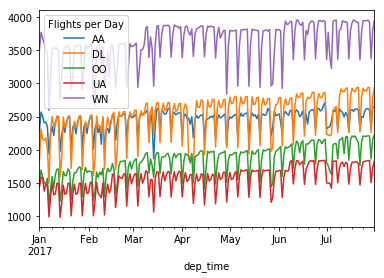

In [19]:
(flights
 .dropna(subset=['dep_time', 'unique_carrier'])
 .loc[flights['unique_carrier'].isin(flights['unique_carrier']
                                .value_counts()
                                .index[:5])]
 .set_index('dep_time')
 .groupby(['unique_carrier', pd.TimeGrouper("D")])
 ["fl_num"]
 .count()
 .unstack(0)
 .fillna(0)
 .rename_axis("Flights per Day", axis=1)
 .plot()
)


If we broke this out like many people do, we might end up with code like this, where each step is broken into a variable.

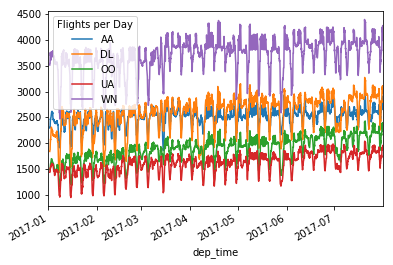

In [20]:
# gets the carriers with the most traffic, hacking with the index. We use this for other ops. 
df_clean = flights.dropna(subset=["dep_time", "unique_carrier"])
top_carriers = flights["unique_carrier"].value_counts().index[:5]
df_clean = df_clean.query("unique_carrier in @top_carriers")
df_clean = df_clean.set_index("dep_time")

carriers_by_hour = (df_clean
                    .groupby(['unique_carrier',
                              pd.TimeGrouper("H")])["fl_num"]
                    .count())
carriers_df = carriers_by_hour.unstack(0)
carriers_df = carriers_df.fillna(0)
carriers_flights_per_day = (carriers_df
                            .rolling(24)
                            .sum()
                            .rename_axis("Flights per Day", axis=1))

carriers_flights_per_day.plot()

Naming things is hard. Given that pandas has exteremely expressive semantics and nearly all analytic methods return a fresh dataframe or series, it makes it straightforward to chain many ops together. This style will lend itself well to spark and should be familiar to those of you who have worked with Scala or other functional languages.

If the chains get very verbose or hard to follow, break them up and put them in a function, where you can keep it all in one place. Try to be very specific about naming your functions (remember, naming things is hard, functions are no different).


In an exploratory context, you might continue adding methods onto your chain until you can expand and continue until you get to your chart or end stage goal. In some cases, saving some exploratory work to varibles is great. 


Let's briefly talk about the `.assign` operator. This operation returns a new column for a dataframe, where the new column can be a constant, some like-indexed numpy array or series, a callable that references the dataframe in question, etc. It's very powerful in method chains and also very useful for keeping your namespace clean.

the semantics of 

`df.assign(NEW_COLUMN_NAME=lambda df: df["column"] + df["column2"]`
can be read as

assign a column named "NEW_COLUMN_NAME" to my referenced dataframe that is the sum of "column" and "column2". In the below example , the lambda references the datetime object of the departure time column to extract the hour, which gives us a convenient categorical value for examination.


This is similar to R's `mutate` function in the dyplr world.


Note -- the `top_carriers` variable above is a good example of something we might want to keep around, and I'll use it several times in the post.

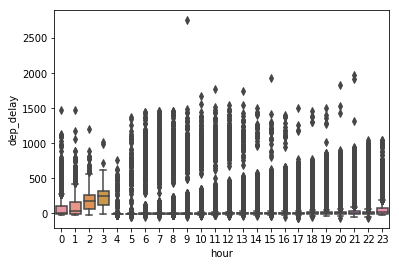

In [21]:
#taken from Augsperger
(flights[['fl_date', 'unique_carrier', 'tail_num', 'dep_time', 'dep_delay']]
 .dropna()
 .query("unique_carrier in @top_carriers")
 .assign(hour=lambda x: x['dep_time'].dt.hour)
 #.query('5 <= dep_delay < 600')
 .pipe((sns.boxplot, 'data'), 'hour', 'dep_delay')
)

This enables rapid exploration, and within the interactive context, allows you to copy a cell and change single lines to modify your results. 

A heatmap might be a nice way to visualize categories in this data, and the `assign` syntax allows creating those categoricals seamless.

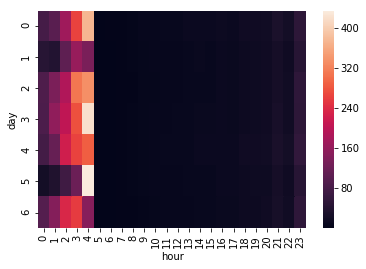

In [22]:
(flights[['fl_date', "unique_carrier", 'dep_time', 'dep_delay']]
 .dropna()
 .query("unique_carrier in @top_carriers")
 .assign(hour=lambda x: x.dep_time.dt.hour)
 .assign(day=lambda x: x.dep_time.dt.dayofweek)
 .query('-1 < dep_delay < 600')
 .groupby(["day", "hour"])["dep_delay"]
 .median()
 .unstack()
 .pipe((sns.heatmap, 'data'))
)

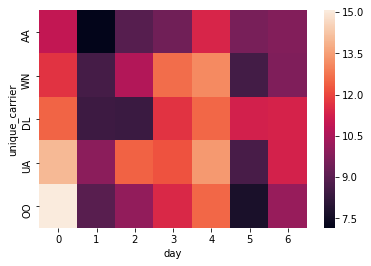

In [23]:
(flights[['fl_date', 'unique_carrier', 'dep_time', 'dep_delay']]
 .query("unique_carrier in @top_carriers")
 .dropna()
 .assign(hour=lambda x: x.dep_time.dt.hour)
 .assign(day=lambda x: x.dep_time.dt.dayofweek)
 #.query('0 <= dep_delay < 600')
 .groupby(["unique_carrier", "day"])["dep_delay"]
 .mean()
 .unstack()
 .sort_values(by=0)
 .pipe((sns.heatmap, 'data'))
)

What about some other exploration? Pandas alows for some nifty ways of slicing up data to flexibly apply basic operations.

What if we want to "center" the carrier's delay time at an airport by the mean airport delay? This is a case where we assigning variables might be useful. We'll limit our analysis to the top carrriers / airports, and save some variables for further interactive use.

In [24]:
top_airport_codes = flights["origin"].value_counts().to_frame().head(5).index
top_airport_cities = flights["origin_city_name"].value_counts().head(5).index
top_airport_cities
top_airport_codes

Index(['Atlanta', 'Chicago', 'Denver', 'Los Angeles', 'New York'], dtype='object')

CategoricalIndex(['ATL', 'ORD', 'DEN', 'LAX', 'DFW'], categories=['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', ...], ordered=False, dtype='category')

In [26]:
grand_airport_delay = (flights
 .query("unique_carrier in @top_carriers")
 .query("origin in @top_airport_codes")
 .groupby("origin")["dep_delay"] 
 .mean()
 .dropna()
 .to_frame()
)

airport_delay = (flights
.query("unique_carrier in @top_carriers")
.query("origin in @top_airport_codes")
 .set_index("fl_date")
 .groupby([pd.TimeGrouper("H"), "origin"])["dep_delay"] 
 .mean()
 .to_frame()
)

carrier_delay = (flights
.query("unique_carrier in @top_carriers")
.query("origin in @top_airport_codes")
 .set_index("fl_date")
 .groupby([pd.TimeGrouper("H"), "origin", "unique_carrier"])["dep_delay"] 
 .mean()
 .to_frame()
)

airport_delay.head()
carrier_delay.head()

dep_delay
fl_date    origin           
2017-01-01 ATL     10.087558
           DEN      7.821632
           DFW     16.054201
           LAX     20.769231
           ORD      6.972477

dep_delay
fl_date    origin unique_carrier           
2017-01-01 ATL    AA              13.187500
                  DL               6.711900
                  OO              25.769231
                  UA              10.875000
                  WN              21.075630

In [27]:
grand_airport_delay
airport_delay.unstack().head()
carrier_delay.unstack(1).head()

,dep_delay
origin,
ATL,12.177453
DEN,9.247587
DFW,12.203081
LAX,15.547959
ORD,13.054121


dep_delay                                            
origin            ATL        DEN        DFW        LAX        ORD
fl_date                                                          
2017-01-01  10.087558   7.821632  16.054201  20.769231   6.972477
2017-01-02  30.086250  18.655417  22.660194  30.884615  16.823409
2017-01-03   7.546154  19.431942  13.342365  28.501035  15.668737
2017-01-04   4.622887  33.671674   9.635443  22.471239   9.388889
2017-01-05   7.346547  38.205240  16.155556  48.882353  16.287946

dep_delay                                   \
origin                           ATL        DEN        DFW        LAX   
fl_date    unique_carrier                                               
2017-01-01 AA              13.187500  35.961538  17.597633  40.432203   
           DL               6.711900   6.600000  -3.125000  10.985714   
           OO              25.769231   4.373016   5.166667  14.280899   
           UA              10.875000   7.126437  -5.545455  11.950617   
           WN              21.075630   6.983425        NaN  17.645455   

                                     
origin                          ORD  
fl_date    unique_carrier            
2017-01-01 AA              6.557576  
           DL              8.750000  
           OO              6.135135  
           UA              7.940789  
           WN                   NaN

Pandas handles alignment along axes, so we can do an operation along an axis with another dataframe with similar index labels. 

In [28]:
(carrier_delay
 .unstack(1)
 .div(grand_airport_delay.unstack())
 .head()
 
)
(carrier_delay
 .unstack(1)
 .div(airport_delay.unstack())
 .head()
 
)

dep_delay                                        
origin                          ATL       DEN       DFW       LAX       ORD
fl_date    unique_carrier                                                  
2017-01-01 AA              1.082944  3.888749  1.442065  2.600483  0.502338
           DL              0.551174  0.713700 -0.256083  0.706570  0.670286
           OO              2.116143  0.472882  0.423390  0.918506  0.469977
           UA              0.893044  0.770627 -0.454431  0.768629  0.608298
           WN              1.730709  0.755162       NaN  1.134905       NaN

dep_delay                                        
origin                          ATL       DEN       DFW       LAX       ORD
fl_date    unique_carrier                                                  
2017-01-01 AA              1.307304  4.597703  1.096139  1.946736  0.940494
           DL              0.665364  0.843814 -0.194653  0.528942  1.254934
           OO              2.554556  0.559093  0.321826  0.687599  0.879908
           UA              1.078061  0.911119 -0.345421  0.575400  1.138876
           WN              2.089270  0.892835       NaN  0.849596       NaN

Putting that together, we can then get ratios of flight delays to the overall airport delay (grand mean or daily delays).

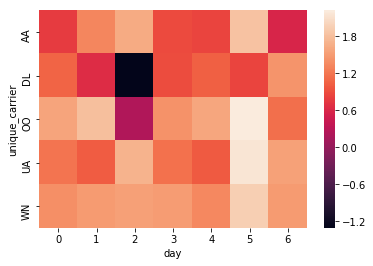

In [29]:
(carrier_delay
 .unstack(1)
 .div(airport_delay.unstack())
 .stack()
 .reset_index()
 .assign(day=lambda x: x["fl_date"].dt.dayofweek)
 .set_index("fl_date")
 .groupby(["unique_carrier", "day"])
 .mean()
 .dropna()
 .unstack()
 ["dep_delay"]
 .pipe((sns.heatmap, 'data'))
)

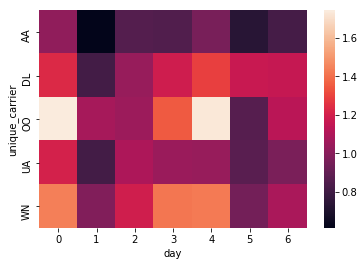

In [30]:
(carrier_delay
 .unstack(1)
 .div(grand_airport_delay.unstack())
 .stack()
 .reset_index()
 .assign(day=lambda x: x["fl_date"].dt.dayofweek)
 .set_index("fl_date")
 .groupby(["unique_carrier", "day"])
 .mean()
 .dropna()
 .unstack()
 ["dep_delay"]
 .pipe((sns.heatmap, 'data'))
)

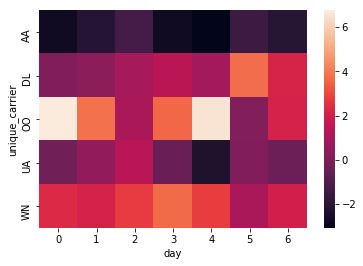

In [31]:
(carrier_delay
 .unstack(1)
 .subtract(airport_delay.unstack())
 .stack()
 .reset_index()
 .assign(day=lambda x: x["fl_date"].dt.dayofweek)
 .groupby(["unique_carrier", "day"])
 .mean()
 .dropna()
 .unstack()
 ["dep_delay"]
 .pipe((sns.heatmap, 'data'))
)

So, now that we have some working flight data, let's poke at getting some tweets.

## Tweets

I've recently refactored the python gnip search api to be a bit more flexible, including making each search return a lazy stream. There are also some tools for programatically generated

the 'city name' column and the airport abbreviation are likely sources of help for finding tweets related to flights / airport data. We'll use those and define a small function to help quickly generate our rules, which are somewhat simplistic but should serve as a reasonable start.



In [32]:
def generate_rules(codes, cities):
    base_rule = """
    ({code} OR "{city} airport") (flying OR flight OR plane OR jet)
    -(football OR
    basketball OR
    baseball OR
    party)
    -is:retweet
    """
    rules = []
    for code, city in zip(list(codes), list(cities)):
        _rule = base_rule.format(code=code, city=city.lower())
        rule = gen_rule_payload(_rule,
                                from_date="2017-01-01",
                                to_date="2017-07-31",
                                max_results=500)
        rules.append(rule)
    return rules

gnip_rules = generate_rules(top_airport_codes, top_airport_cities)
gnip_rules[0]

'{"query":"(ATL OR \\"atlanta airport\\") (flying OR flight OR plane OR jet) -(football OR basketball OR baseball OR party) -is:retweet","maxResults":500,"toDate":"201707310000","fromDate":"201701010000"}'

the gnip api has some functions to handle our connection information. Please ensure that the environment variable `GNIP_PW` is set with your password. If it isn't already set, you can set it here.

In [ ]:
# os.environ["GNIP_PW"] = ""

In [ ]:
username = "agonzales@twitter.com"
search_api = "fullarchive"
account_name = "shendrickson"
endpoint_label = "ogformat.json"
og_search_endpoint = gen_endpoint(search_api,
                                  account_name,
                                  endpoint_label,
                                  count_endpoint=False)
og_args = {"username": username,
           "password": os.environ["GNIP_PW"],
           "url": og_search_endpoint}

In our `get_tweets` function, we wrap some of the functionality of our result stream to collect specific data from tweets into a dataframe.


In [ ]:
def get_tweets(result_stream, label):
    fields = ["id", "created_at_datetime",
              "all_text", "hashtags", "user_id",
              "user_mentions", "screen_name"]
    
    tweet_extracts = []
    for tweet in result_stream.start_stream():
        attrs = [tweet.__getattribute__(field) for field in fields]
        tweet_extracts.append(attrs)
        
    result_stream.end_stream()
    df = pd.DataFrame(tweet_extracts, columns=fields).assign(airport=label)
    return df


We can test this with a single rule.

In [ ]:
rs = ResultStream(**og_args, rule_payload=gnip_rules[0], max_results=1000)

In [ ]:
tweets = get_tweets(result_stream=rs, label=top_airport_codes[0])

In [ ]:
tweets.head()
tweets.shape

Now let's collect tweets for each airport. It might be a hair overkill, but I'll  wrap the process up in a function, so we have a similar high point for grabbing our inital data. It will take a minute to grab this data, and for the time being, i'm not going to save it to disk.

In [ ]:
def pull_tweet_data(gnip_rules, results_per_rule=25000):
    streams = [ResultStream(**og_args,
                            rule_payload=rp,
                            max_results=results_per_rule)
               for rp in gnip_rules]

    tweets = [get_tweets(rs, airport)
              for rs, airport
              in zip(streams, top_airport_codes)]
    
    return pd.concat(tweets)

In [ ]:
tweets = pull_tweet_data(gnip_rules)

Given our new data, let's do some quick exploration and cleaning.

In [ ]:
tweets.shape
tweets.head()

In [ ]:
(tweets
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("D")])
 .size()
 .sort_values()
 .tail()
)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
(tweets
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("D")])
 .size()
 .plot()
)
 
ax.annotate("united senselessly\nbeating a passenger",
            xytext=("2017-02-01", 1200),
            xy=("2017-04-04", 900),
            arrowprops=dict(facecolor="black", shrink=0.05))

The number of tweets per day by airport rule is a bit odd:

In [ ]:
(tweets
 .drop(["id", "all_text"], axis=1)
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("H"), "airport"])
 ["user_id"]
 .count()
 .unstack()
 .fillna(0)
 .rolling(24).sum()
 .plot()
)
 

So lets look at what is going on with LAX:

In [ ]:
tweets["airport"].value_counts()
tweets.groupby("airport")["created_at_datetime"].min().sort_values().tail(1)
min_lax_time = tweets.groupby("airport")["created_at_datetime"].min().sort_values().tail(1)[0]

Far, far more people tweeting from  LAX than from other airports or the number of extra tweets were dominated by the spikes in the data. Given it's size, this makes some sense, but i would question my rules a bit. Let's even out these samples a hair, by selecting tweets only from when LAX exisited

In [ ]:
(tweets
.drop(["id", "all_text"], axis=1)
.query("created_at_datetime >= @min_lax_time")
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("D"), "airport"])
 ["user_id"]
 .count()
 .unstack()
 .fillna(0)
 #.rolling(7).mbean()
 .plot()
)
 

Moving on, let's do some more things with our tweets, like parse out the mentions from the dict structure to something more useful.


We'll be making a function that takes a dataframe and returns one, so we can use it in the `.pipe` method.

In [ ]:
def parse_mentions(df):
    extract_mentions = lambda x: [d["name"] for d in x]
    mentions = (pd.DataFrame([x for x in df["user_mentions"]
                              .apply(extract_mentions)])
                .loc[:, [0, 1]]
                .rename(columns={0: "mention_1", 1: "mention_2"})
               )
    
    return (pd.merge(df,
                      mentions,
                      left_index=True,
                      right_index=True)
             .drop("user_mentions", axis=1)
            )
    

In [ ]:
airline_name_code_dict = {
    "Southwest Airlines": "WN",
    "Delta": "DL",
    "American Airlines": "AA",
    "United Airlines": "UA",
    "Sky": "Sk"
}

now, what about labeling a row with strictly American Airlines mentions? We could do this a few ways... 

In [ ]:
(tweets
 .pipe(parse_mentions)
 .assign(AA=lambda df: (df["mention_1"] == "American Airlines") |
         (df["mention_2"] == "American Airlines"))
 .query("AA == True")
 .head()
 

)

In [ ]:
(tweets
 .pipe(parse_mentions)
 .query("mention_1 == 'American Airlines' or mention_2 == 'American Airlines'")
 .shape
)

In [ ]:
(tweets
 .pipe(parse_mentions)
 .query("mention_1 == 'American Airlines' or mention_2 == 'American Airlines'")
 .query("created_at_datetime >= @min_lax_time")
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("D"), "airport"])
 ["user_id"]
 .count()
 .unstack()
 .fillna(0)
 .rolling(7).mean()
 .plot()
)
 

Moving on a bit, what about a simple sentiment model? We'll grab a word database that simply matches words to a value and use it as a simple baseline.

In [ ]:
from nltk.tokenize import TweetTokenizer

def get_affin_dict():
    url = "https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-111.txt"
    affin_words = (pd
                   .read_table(url,
                               sep='\t',
                               header=None)
                   .rename(columns={0: "word", 1: "score"})
                   .to_dict(orient="list")
                  )
    affin_words = {k: v for k, v in
                   zip(affin_words["word"],
                       affin_words["score"])}
    return affin_words



tknizer = TweetTokenizer()

def score_sentiment(words):
    words = set(words) 
    union = words & affin_words.keys()
    return sum([affin_words[w] for w in union])
    
def score_tweet(tweet_text):
    return score_sentiment(tknizer.tokenize(tweet_text))

affin_words = get_affin_dict()

In [ ]:
(tweets
 .assign(sentiment=lambda df: df["all_text"].apply(score_tweet))
 ["sentiment"]
 .plot.hist(bins=20))

In [ ]:
(tweets
 .assign(sentiment=lambda df: df["all_text"].apply(score_tweet))
 .pipe(lambda df: pd.concat([df.query("sentiment <= -5").head(),
                            df.query("sentiment >= 5").head()]))
)

seems semi-reasonable to me!

Let's look at a timeseries of sentiment overall:

In [ ]:
(tweets
 .assign(sentiment=lambda df: df["all_text"].apply(score_tweet))
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("D")])
 ["sentiment"]
 .mean()
 .rolling(2).mean()
 .plot()
)
 

Since we have our reasonable sentiment and mentions data, let's assign it to a fresh dataframe and continue looking. 

Note that a full data pull step at this point might look like

```.python
tweets = (pull_tweet_data(gnip_rules)
          .pipe(parse_mentions)
          .assign(sentiment=lambda df: df["all_text"].apply(score_tweet))
         )
```

In [ ]:
tweets = (tweets
          .pipe(parse_mentions)
          .assign(sentiment=lambda df: df["all_text"].apply(score_tweet))
         )

And let's do some basic exploration of our tweet data.

In [ ]:
(tweets
 .groupby(["airport"])
 ["sentiment"]
 .mean()
 .sort_values()
 .plot.barh()
)

In [ ]:
(tweets
 .assign(day=lambda x: x.created_at_datetime.dt.dayofweek)
 .assign(hour=lambda x: x.created_at_datetime.dt.hour)
 .groupby(["day", "hour"])
 ["sentiment"]
 .mean()
 .unstack()
 .pipe((sns.heatmap, 'data') )
)

In [ ]:
(tweets
 .assign(hour=lambda x: x.created_at_datetime.dt.hour)
 .assign(day=lambda x: x.created_at_datetime.dt.dayofweek)
 .groupby(["airport", "day"])
 ["sentiment"]
 .mean()
 .unstack()
 .sort_values(by=0)
 .pipe((sns.heatmap, 'data') )
)

In [ ]:
(tweets
 .assign(hour=lambda x: x.created_at_datetime.dt.hour)
 .groupby(["airport", "hour"])
 ["sentiment"]
 .mean()
 .unstack()
 .sort_values(by=0)
 .pipe((sns.heatmap, 'data'))
)

In [ ]:
(tweets
 .assign(day=lambda x: x.created_at_datetime.dt.dayofweek)
 .query("airport == 'ATL' and day == 2")
 .sample(10)
 .all_text
       )

(tweets
 .assign(day=lambda x: x.created_at_datetime.dt.dayofweek)
 .query("airport == 'ATL' and day == 5")
 .sample(10)
 .all_text
       )

In [ ]:
tweet_sent_airport = (tweets
 .set_index("created_at_datetime")
 .groupby([pd.TimeGrouper("D"), "airport"])["sentiment"]
 .mean()
)

In [ ]:
delay_sent = (pd.concat([airport_delay, tweet_sent_airport],
                        axis=1,
                        names=("day", "airport"))
              .sort_index())

In [ ]:
for code in top_airport_codes:
    (delay_sent
     .loc[pd.IndexSlice[:, code], :]
     .plot(subplots=True, title="Sentiment and delay time at {}".format(code)))

In [ ]:
delay_sent.loc[pd.IndexSlice[:, "ATL"], :].corr()

In [ ]:
delay_sent.groupby(level=1).corr().T.loc["sentiment"].unstack()["dep_delay"].sort_values()